### Import Libraries

In [1]:
import re
import string 

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Loading Data

In [2]:
train_df = pd.read_csv('./toxic_classification/train.csv').fillna(' ')

train_df.sample(10, random_state = 1234)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
12345,20bc45f5014c1eca,"""\n\nYour latest edit has again had to be remo...",0,0,0,0,0,0
55587,948580166b8b8745,"""\n\nWorks for me. BaStun not BaTsun """,0,0,0,0,0,0
16877,2c8519885db5c0bb,List of newspapers in India by readership\n\nT...,0,0,0,0,0,0
140039,ed64d530a34aa973,Happy New Years\nCheers ),0,0,0,0,0,0
125777,a0dd897eafbada2c,Photos \nSouthwestern’s official website has m...,0,0,0,0,0,0
159512,ff2f5695bb9aa845,"How's this? It's a lot shorter, but it's more ...",0,0,0,0,0,0
121612,8aa46e67645e4b7b,Why did you remove skinwalker instead of movin...,0,0,0,0,0,0
7588,142d9e745d03c9ef,"""I repeat, the text was about a minority schoo...",0,0,0,0,0,0
9463,191a1c6bd40ad470,bay pigs article \n\nhi i noticed that you wer...,1,0,1,0,0,0
103236,287b2d375ed7188a,"MusikAnimal is a liar, a disinformant and plag...",0,0,0,0,0,0


In [3]:
def clean_text(text):
    text =  text.lower()
    # Change abbreviation
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    # Remove special characters/punctuation 
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub("(\\W)"," ",text) 
    # Remove spaces and digits
    text = re.sub('\S*\d\S*\s*','', text)
    
    return text

train_df['comment_text'] = train_df['comment_text'].apply(lambda x:clean_text(x))

In [4]:
# Show the comments
x = train_df['comment_text'].values 
print(x)

['explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired '
 'daww he matches this background colour i am seemingly stuck with thanks  talk january utc'
 'hey man i am really not trying to edit war it is just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info'
 ...
 'spitzer   umm theres no actual article for prostitution ring   crunch captain'
 'and it looks like it was actually you who put on the speedy to have the first version deleted now that i look at it'
 ' and  i really do not think you understand  i came here and my idea was bad right away  what kind of community goes you have bad ideas go away instead of helping rewrite them   ']


In [5]:
# Show 10 random toxic comments
train_df.loc[train_df['toxic'] == 1].sample(10, random_state=1234)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
86296,e6cfe09510b15145,and are angelique kkkarringtonhating jews,1,0,0,0,0,0
8619,16e110672dde00d9,how civil is this who the fuck do you think y...,1,1,1,0,1,0
123695,958e4d243a743156,idiot i do not understand what user fuc...,1,0,1,0,1,0
120058,820861d281284864,i would hoped for a better more neutral respon...,1,0,0,0,0,0
157801,e381fcf1759b1d0f,comments from the west are irrelevant we may...,1,0,0,0,0,0
132607,c57242ec5816d21c,your mom is so fat she gets cashback when sh...,1,1,1,0,1,1
73811,c580d59f2a359dcc,user talkjesserafetalk how dare you call me ra...,1,0,0,0,1,0
17995,2f85b9f5219235df,to be honest with you if you do not tell me a ...,1,0,0,0,0,0
45799,7a675e86c2e62890,ps i need some penis cat tongue is getting old,1,0,1,0,0,0
148162,47cf25a86ba2dc49,fuck all modernists i wish the roman empire ...,1,0,1,0,0,0


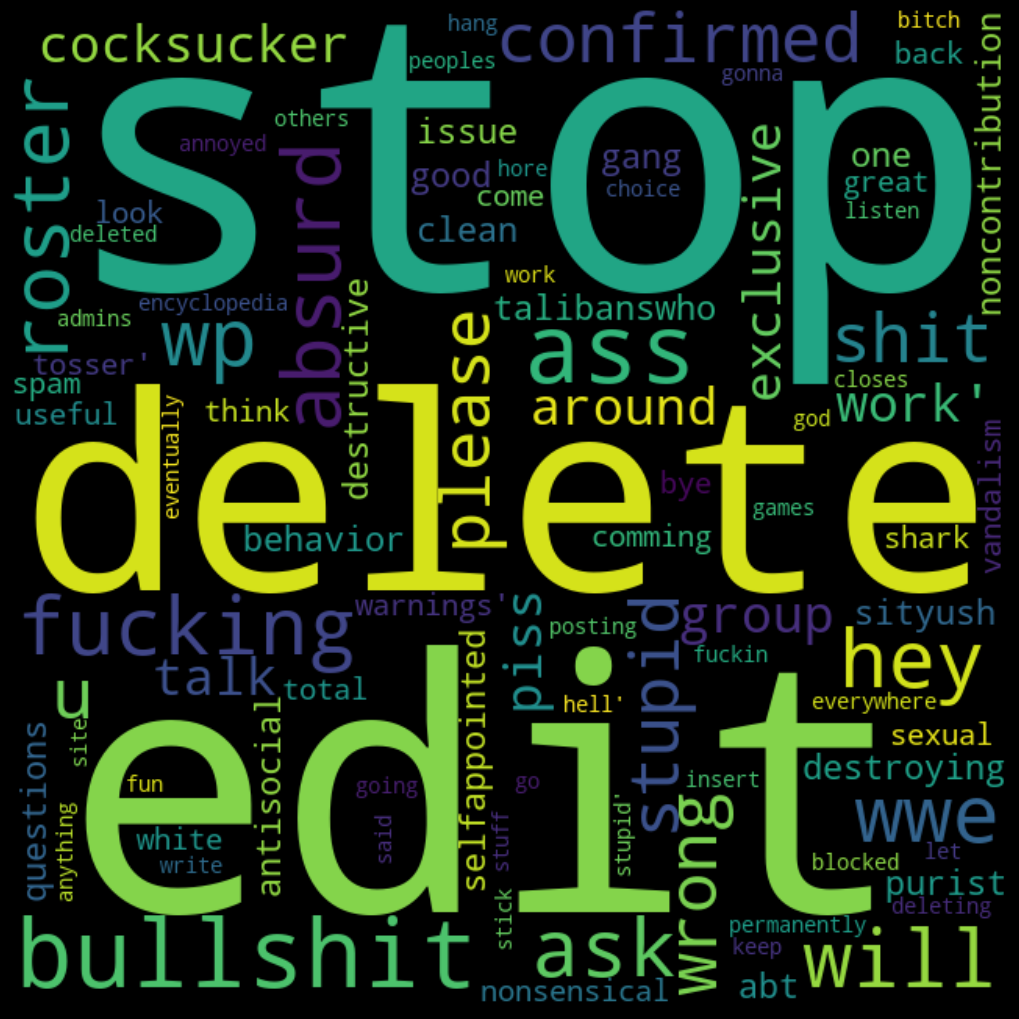

In [6]:
# Display toxic words that are often used
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS
).generate(str(comments))

fig = plt.figure(
    figsize = (15, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show() 

In [7]:
# Distribution of toxic comments (0 = not toxic, 1 = toxic)
train_df['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

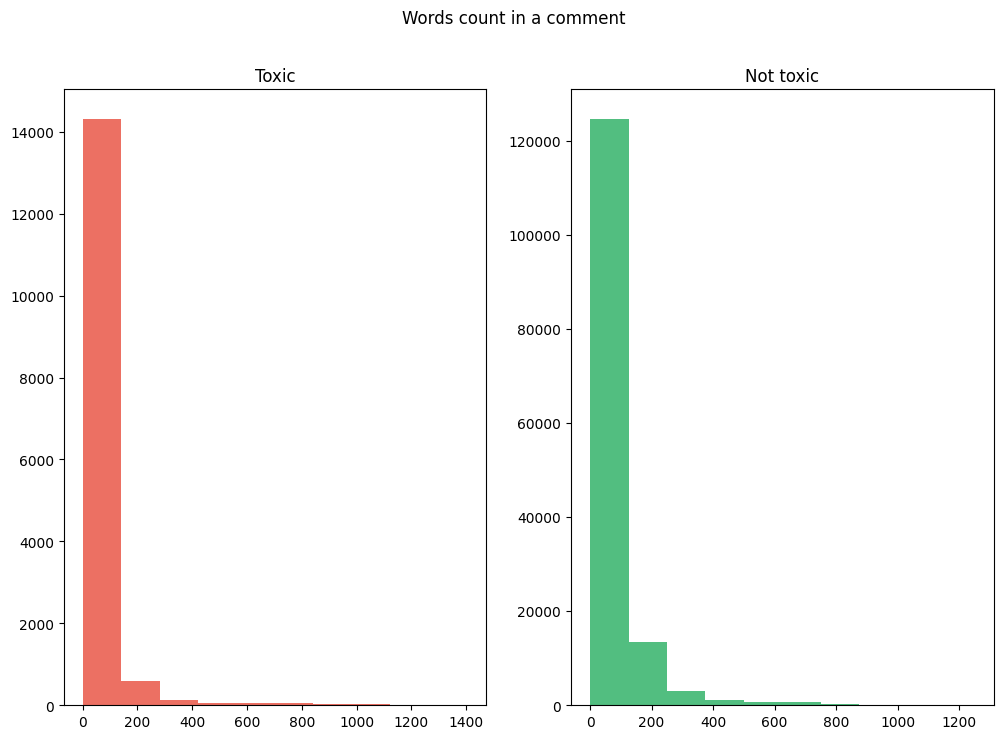

In [10]:
# Words count in a comment
fig,(ax1,ax2)=plt.subplots(1,2,figsize = (12,8))
comment_len=train_df[train_df['toxic']==1]['comment_text'].str.split().map(lambda x: len(x))
ax1.hist(comment_len,color = '#EC7063')
ax1.set_title('Toxic')

comment_len=train_df[train_df['toxic']==0]['comment_text'].str.split().map(lambda x: len(x))
ax2.hist(comment_len,color = '#52BE80')
ax2.set_title('Not toxic')
fig.suptitle('Words count in a comment')
plt.show()

### Tokenization and Preparation 

In [11]:
max_features = 20000 
max_text_length = 100

x_tokenizer = text.Tokenizer(max_features)
# Create vocabulary index based on word frequency
x_tokenizer.fit_on_texts(list(x))
# Transform each text to a sequence of integers mapped to its index in vocabulary index
x_tokenized = x_tokenizer.texts_to_sequences(x)
# Standardize output shape, longer sequence will be truncated and any shorter will be 0-padded
x_train_val = sequence.pad_sequences(x_tokenized, maxlen = max_text_length)

### Pre-trained GloVe (Global Vectors) Embeddings

In [12]:
embedding_dim = 100 # maximum length for the sequences
embeddings_index = dict()

# Create word embedding matrix for each word in the vocabulary index
f = open('./toxic_classification/glove/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [13]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index > max_features -1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [14]:
# Word embedding for the word 'stop'
embeddings_index.get('stop')

array([ 0.2425   , -0.47787  , -0.13228  , -0.067827 ,  0.18656  ,
        0.50566  , -0.6272   ,  0.62262  ,  0.46563  , -0.2013   ,
        0.10606  , -0.0074248,  0.018328 ,  0.071007 , -0.10155  ,
        0.047794 , -0.23775  , -0.031302 , -0.49632  ,  0.15608  ,
        0.66928  ,  0.25275  , -0.13324  , -0.38499  ,  0.066809 ,
        0.77926  , -0.60947  , -0.2793   ,  0.89159  , -0.014682 ,
       -0.47358  ,  0.46668  ,  0.27529  ,  0.22201  , -0.28549  ,
       -0.32237  , -0.016588 , -0.75657  ,  0.57294  ,  0.019744 ,
       -0.70022  ,  0.21178  , -0.051869 , -0.38181  , -0.059082 ,
        0.31623  ,  0.11617  , -0.50781  , -0.23866  , -0.83731  ,
        0.4407   ,  0.3665   , -0.29323  ,  1.1963   , -0.10997  ,
       -2.1168   , -0.20417  ,  0.094542 ,  1.9624   , -0.057167 ,
       -0.3005   , -0.17937  ,  0.24791  ,  0.0021858,  0.68972  ,
        0.59606  ,  0.46632  ,  0.35762  , -0.42129  , -0.32616  ,
       -0.50294  , -1.0584   , -0.40357  , -0.71748  ,  0.0178

### Create the Embedding Layer 

In [15]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(
                    embedding_matrix), trainable=False))
model.add(Dropout(0.2))

### Build the Model

In [16]:
# Define model parameters
filters = 150
kernel_size = 3
hidden_dims = 150

In [17]:
model.add(Conv1D(filters, kernel_size, activation = 'relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters, kernel_size, activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 150)         45150     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 150)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 150)         67650     
                                                                 
 global_max_pooling1d (Globa  (None, 150)              0         
 lMaxPooling1D)                                         

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training Model

In [19]:
# Split the data
y = train_df['toxic'].values
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y, test_size = 0.30, random_state = 1235)

In [20]:
# Model training
%time
batch_size = 64
epochs = 10

model.fit(x_train, y_train, batch_size = batch_size,
          epochs = epochs, validation_data=(x_val, y_val))

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/10
1746/1746 [==============================] - 41s 23ms/step - loss: 0.1541 - accuracy: 0.9438 - val_loss: 0.1309 - val_accuracy: 0.9520
Epoch 2/10
1746/1746 [==============================] - 40s 23ms/step - loss: 0.1282 - accuracy: 0.9523 - val_loss: 0.1217 - val_accuracy: 0.9561
Epoch 3/10
1746/1746 [==============================] - 40s 23ms/step - loss: 0.1181 - accuracy: 0.9566 - val_loss: 0.1145 - val_accuracy: 0.9576
Epoch 4/10
1746/1746 [==============================] - 40s 23ms/step - loss: 0.1113 - accuracy: 0.9590 - val_loss: 0.1166 - val_accuracy: 0.9579
Epoch 5/10
1746/1746 [==============================] - 40s 23ms/step - loss: 0.1049 - accuracy: 0.9613 - val_loss: 0.1168 - val_accuracy: 0.9577
Epoch 6/10
1746/1746 [==============================] - 40s 23ms/step - loss: 0.0998 - accuracy: 0.9628 - val_loss: 0.1195 - val_accuracy: 0.9551
Epoch 7/10
1746/1746 [==============================] - 41s 23ms/step - loss: 0.0940 

### Model Evaluation

In [22]:
test_df = pd.read_csv('./toxic_classification/test.csv')
test_df['comment_text'] = test_df['comment_text'].apply(lambda x:clean_text(x))

In [23]:
# Show the comments
x_test = test_df['comment_text'].values
print(x_test)

['yo bitch ja rule is more succesful then you will ever be whats up with you and hating you sad mofuckasi should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me ja rule is about pride in da music man dont diss that shit on him and nothin is wrong bein like tupac he was a brother toofuckin white boys get things right next time'
 ' from rfc     the title is fine as it is imo'
 '     sources      zawe ashton on lapland      ' ...
 '     okinotorishima categories     i see your changes and agree this is more correct  i had gotten confused but then found this    while acknowledging japangs territorial rights to okinotorishima itself    however is there a category for     did not acknowledge japangs claim to an exclusive economic zone eez stemming from okinotorishima   that is is there a category for disputed eezs   '
 '     one of the founding nations of the eu  germany  has a law of return quite similar to israels     this is not actually true is it germany

In [24]:
def make_test_predictions(df):
    df.comment_text = df.comment_text.apply(clean_text)
    x_test = df['comment_text'].values
    x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
    x_testing = sequence.pad_sequences(x_test_tokenized, maxlen=max_text_length)
    y_testing = model.predict(x_testing, verbose=1, batch_size=64)
    df['is_toxic'] = ['not toxic' if x[0] < .5 else 'toxic' for x in y_testing]

In [25]:
result = make_test_predictions(test_df)
test_df[['comment_text', 'is_toxic']].head(10)

2394/2394 [==============================] - 16s 7ms/step


,comment_text,is_toxic
0,yo bitch ja rule is more succesful then you wi...,toxic
1,from rfc the title is fine as it is imo,not toxic
2,sources zawe ashton on lapland,not toxic
3,if you have a look back at the source the info...,not toxic
4,i do not anonymously edit articles at all,not toxic
5,thank you for understanding i think very highl...,not toxic
6,please do not add nonsense to wikipedia such e...,not toxic
7,dear god this site is horrible,toxic
8,only a fool can believe in such numbers t...,not toxic
9,double redirects when fixing double redir...,not toxic


In [26]:
comment_text = "thank you, you make me lose sucker"
comment ={'id':[565],'comment_text':[comment_text]}
comment = pd.DataFrame(comment)
result = make_test_predictions(comment)
comment[['comment_text', 'is_toxic']].head(10)

1/1 [==============================] - 0s 16ms/step


,comment_text,is_toxic
0,thank you you make me lose sucker,toxic
